### Load Packages

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
#%matplotlib notebook
from IPython import display
import pandas as pd

import sys, subprocess
from PIL import Image
import pickle
from armcodlib import *
import keras.backend as K
import os
import cv2
from glob import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation


Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.0.0-alpha0


### Create arm positions dataset

Fixing parameters 

In [3]:
NB_POSTURE = 50
NB_COMMAND = 100
NB_DATA = NB_POSTURE*NB_COMMAND
BATCH_SIZE = 100
TEST_BUF = 1000
IMG_SIZE = 128
DIMS = (IMG_SIZE, IMG_SIZE,2)
N_TRAIN_BATCHES =int(NB_DATA/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)


Creation of the training data: 
- train_posture_before : joint angles before command
- train_posture_after  : joint angles after command is applied
- command : command applied
- train_position_before : end effector position before command
- train_position_after : end effector position after command is applied.

Saving the training data

Loading saved data (_not useful in general_)

In [4]:
train_images_pickle = open("pickles/train_images.pickle", "rb")
train_command_pickle = open("pickles/train_command.pickle", "rb")
train_posture_before_pickle = open("pickles/train_posture_before.pickle", "rb")
train_posture_after_pickle = open("pickles/train_posture_after.pickle", "rb")
train_position_before_pickle = open("pickles/train_position_before.pickle","rb")
train_position_after_pickle = open("pickles/train_position_after.pickle", "rb")



train_command = pickle.load(train_command_pickle)
train_images = pickle.load(train_images_pickle)
train_posture_before = pickle.load(train_posture_before_pickle)
train_posture_after = pickle.load(train_posture_after_pickle)
train_position_before = pickle.load(train_position_before_pickle)
train_position_after = pickle.load(train_position_after_pickle)

train_images_pickle.close()
train_command_pickle.close()
train_posture_after_pickle.close()
train_posture_before_pickle.close()
train_position_before_pickle.close()
train_position_after_pickle.close()

Creation of the tf.dataset

In [5]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,1:]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

train_dataset_x = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,],train_images[:,:,:,:0]))
    .repeat(10)
    .shuffle(NB_DATA)
    .batch(BATCH_SIZE)
)

visu_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images[:,:,:,]))
    .repeat(10)
    .shuffle(NB_DATA)
)

### Main convolutional model

Creation, compilation and training of the model.

In [6]:
encoder_conv = build_conv2D_pointwise_encoder()
decoder_dense = build_dense_pointwise_decoder()

Plot the loss function

In [7]:
encoder_conv.load_weights('models/encoder_conv.h5')
decoder_dense.load_weights('models/decoder_dense.h5')

autoencoder_conv = tf.keras.Model(encoder_conv.input,
                                  decoder_dense(encoder_conv(encoder_conv.input)),
                                  name = "autoencoder")

Example of reconstructed image

In [8]:
example_data = next(iter(train_dataset))

In [9]:
res = encoder_conv.predict(example_data)

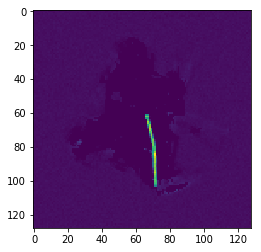

In [10]:
imshow(autoencoder_conv.predict(example_data)[0,:,:,0])

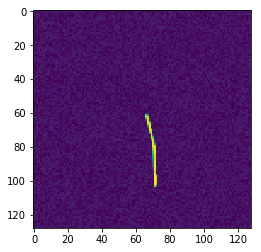

In [11]:
imshow(example_data[0][0,:,:,1])

### Visualization of ConvNet Filters

### Visualization of dense layers

### t-SNE 

### 3D t-SNE animation

## Control model

In [12]:
control_model = build_control_model()

In [14]:
optimizer = tf.keras.optimizers.Adam(1e-3)

control_model.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [19]:
train_control_dataset = prepare_dataset(train_command, 
                                        train_posture_before,
                                       train_posture_after, 
                                       train_position_after, 
                                       train_position_before)

(5000, 1, 5)


In [20]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

history = control_model.fit(train_control_dataset, 
                    epochs = 20)

Epoch 1/20
500/500 [==============================] - 2s 5ms/step - loss: 0.0059 - accuracy: 0.4071 - kullback_leibler_divergence: 0.9206
Epoch 2/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0055 - accuracy: 0.4170 - kullback_leibler_divergence: 0.8984
Epoch 3/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0055 - accuracy: 0.4174 - kullback_leibler_divergence: 0.8977
Epoch 4/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0055 - accuracy: 0.4174 - kullback_leibler_divergence: 0.8972
Epoch 5/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0055 - accuracy: 0.4163 - kullback_leibler_divergence: 0.8947
Epoch 6/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0054 - accuracy: 0.4169 - kullback_leibler_divergence: 0.8937
Epoch 7/20
500/500 [==============================] - 2s 3ms/step - loss: 0.0054 - accuracy: 0.4170 - kullback_leibler_divergence: 0.8924
Epoch 8/20
500/500 [==============

In [21]:
control_model.save('models/control_model.h5')

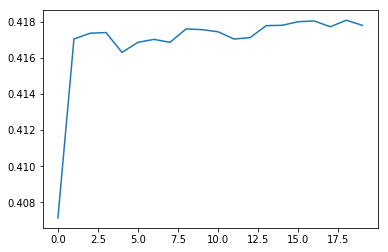

In [22]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.show()

#### Example


In [23]:
example_data = next(iter(train_control_dataset))
res = control_model.predict(example_data)
shape(example_data)
mean(res - example_data[1])

0.00392091223080795

In [77]:
current_posture = np.array([[0.3,0.3,0.2, 0.2, 0.1]])
visual_direction = np.array([0,0,1])

postures = test_visuomotor_control(control_model, current_posture, visual_direction)
t = compute_trajectory(postures)


<IPython.core.display.Javascript object>


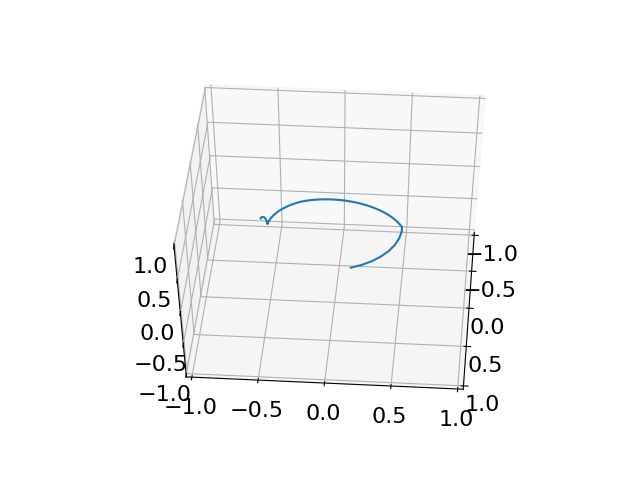

In [78]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(t[:,0], t[:,1], t[:,2])

In [150]:
def compute_trajectory(postures):
    tmp = []
    print shape(postures)
    for i in range(len(postures)):
        tmp.append(control_robot(postures[i][0]))
    return np.array(tmp)




In [173]:
def go_to_position(control_model, current_posture, target_position, nb_pass = 500):
    postures = []
    vd = []


    visual_direction = compute_vd_from_position(target_position, current_posture)

    postures.append(current_posture)
    vd.append((visual_direction))
    j = 0
    while (j < nb_pass) and (np.linalg.norm(target_position - np.array(control_robot(current_posture[0]))) > 0.1):


        inputs = np.expand_dims(np.concatenate([visual_direction, current_posture], axis=0), 0)

        new_command = control_model.predict(inputs)

        #new_command = command_bornee(new_command)
        current_posture = current_posture + new_command[0]
        current_posture = check_valid_posture(current_posture)

        visual_direction = compute_vd_from_position(target_position, current_posture)

        postures.append(current_posture)
        vd.append((visual_direction))
        visual_direction = compute_vd_from_position(target_position, current_posture)/np.linalg.norm(visual_direction)
        j +=1

    return postures, np.array(vd)


In [174]:
target_position = [[0.2,0.24,-0.2]]
postures, vd = go_to_position(control_model, current_posture, target_position)
t = compute_trajectory(postures)


(378, 1, 5)
(378, 3)


<IPython.core.display.Javascript object>


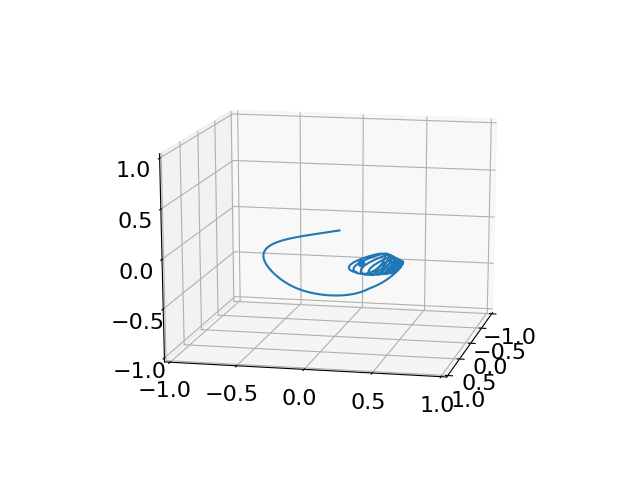

In [172]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(t[:,0], t[:,1], t[:,2])
ax.scatter(target_position[0][0],target_position[0][1],target_position[0][2])


#### Error between asked and executed constant visual direction mvmt 

### Control model with orientation 

In [188]:
def get_end_effector_orientation(angles):
    """function calculating end effector postion from joint angles

    Args :
        phi1, phi2, theta1, theta2 : joint angles (4 dof arm )

    Returns:
        x,y,z : end effector position
        vx,vy,vz : speed i guess...
    """
    phi1, phi2, theta1,psi1, psi2 = angles
 
    
    return np.array([psi1, psi2])


def prepare_dataset_with_orientation(train_command, train_posture_before, train_posture_after, train_position_after, train_position_before):

    t_before = map(lambda x : x[0,:], train_posture_before)
    t_before = np.expand_dims(t_before, 1)
    
    
    t_after = map(lambda x : x[0,:], train_posture_after)
    t_after = np.expand_dims(t_after, 1)
    
    t_command = map(lambda x : x[0,:], train_command)
    t_command = np.expand_dims(t_command, 1)
    
    
    orientation_before = np.array(map(lambda x : get_end_effector_orientation(x), t_before[:,0,:]))
    orientation_after = np.array(map(lambda x : get_end_effector_orientation(x), t_after[:,0,:]))
    
    t_orientation = orientation_after - orientation_before
    t_orientation = np.expand_dims(orientation, 1)

    
    t_visual_direction = normalize_vect(train_position_after - train_position_before)
    #t_visual_direction = padding(t_visual_direction, 2)

    info = np.concatenate((t_visual_direction, t_orientation), axis=2)
    
    tmp_input = np.concatenate([info, t_before], axis = 1)
    
    train_control_dataset = (
        tf.data.Dataset.from_tensor_slices((tmp_input, t_command))
        .repeat(10)
        .shuffle(NB_DATA)
        .batch(100)
        )

    return train_control_dataset

def build_control_orientation_model():
    """ visual_direction and posture before as input
        motor command as output
    """
    LATENT_DIM = 32
    inputs = tf.keras.layers.Input(shape=(2,5))

    h = tf.keras.layers.Lambda(lambda x: x[:,0,:])(inputs)
    p = tf.keras.layers.Lambda(lambda x: x[:,1,:])(inputs)

    h = tf.keras.layers.Reshape((1,5))(h)
    p = tf.keras.layers.Reshape((1,5))(p)

    fh = tf.keras.layers.Flatten()(h)
    fh = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_h_1')(fh)
    fh = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_h_2')(fh)
    fh = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_h_3')(fh)
    #fh = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_h_4')(fh)
    fh = tf.keras.layers.Reshape((LATENT_DIM, 1))(fh)

    fp = tf.keras.layers.Flatten()(p)
    fp = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_p_1')(fp)
    fp = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_p_2')(fp)
    fp = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_p_3')(fp)
    #fp = tf.keras.layers.Dense(LATENT_DIM, name = 'dense_p_4')(fp)
    fp = tf.keras.layers.Reshape((LATENT_DIM,1))(fp)

    matmul = tf.keras.layers.Multiply()([fp, fh])

    fy = tf.keras.layers.Flatten()(matmul)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_1')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_2')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_3')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_y_4')(fy)
    fy = tf.keras.layers.Dense(5, name = 'latent_y_out')(fy)
    fy = tf.keras.layers.Reshape((1,5))(fy)

    outputs = fy

    model = tf.keras.Model(inputs = inputs, outputs = outputs, name='control_model')

    return model

In [189]:
db = prepare_dataset_with_orientation(train_command,
                                      train_posture_before,
                                      train_posture_after,
                                      train_position_after,
                                      train_position_before)

[[[-0.43162838  0.39772266  0.80963796  0.07983717 -0.09416317]]

 [[ 0.35445473  0.8696964  -0.34349676 -0.04780805 -0.03338098]]

 [[ 0.37786877 -0.09215911 -0.92126104  0.08508875 -0.09356446]]

 ...

 [[ 0.91512328 -0.28524865  0.2849256   0.01818719  0.04081511]]

 [[-0.88758636  0.45956249 -0.03150816 -0.01257108  0.04049011]]

 [[-0.86906761  0.46126482 -0.17876315 -0.01971725  0.07673005]]]


[[[-0.43162838  0.39772266  0.80963796  0.07983717 -0.09416317]]

 [[ 0.35445473  0.8696964  -0.34349676 -0.04780805 -0.03338098]]

 [[ 0.37786877 -0.09215911 -0.92126104  0.08508875 -0.09356446]]

 ...

 [[ 0.91512328 -0.28524865  0.2849256   0.01818719  0.04081511]]

 [[-0.88758636  0.45956249 -0.03150816 -0.01257108  0.04049011]]

 [[-0.86906761  0.46126482 -0.17876315 -0.01971725  0.07673005]]]
Epoch 1/30
500/500 [==============================] - 2s 5ms/step - loss: 0.0052 - accuracy: 0.4802 - kullback_leibler_divergence: 0.7073
Epoch 2/30
500/500 [==============================] - 1s 3ms/step - loss: 0.0040 - accuracy: 0.5690 - kullback_leibler_divergence: 0.5123
Epoch 3/30
500/500 [==============================] - 1s 3ms/step - loss: 0.0040 - accuracy: 0.5714 - kullback_leibler_divergence: 0.5092
Epoch 4/30
500/500 [==============================] - 1s 3ms/step - loss: 0.0040 - accuracy: 0.5722 - kullback_leibler_divergence: 0.5085
Epoch 5/30
500/500 [==========================

<IPython.core.display.Javascript object>


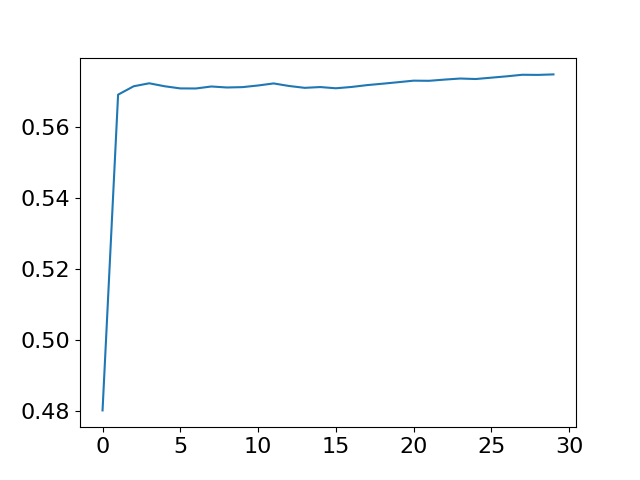

In [190]:
control_model_with_orientation = build_control_orientation_model()
optimizer = tf.keras.optimizers.Adam(1e-3)

control_model_with_orientation.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])
train_control_orientation_dataset = prepare_dataset_with_orientation(train_command, 
                                        train_posture_before,
                                       train_posture_after, 
                                       train_position_after, 
                                       train_position_before)


log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

history = control_model_with_orientation.fit(train_control_orientation_dataset, 
                    epochs = 30)


<IPython.core.display.Javascript object>


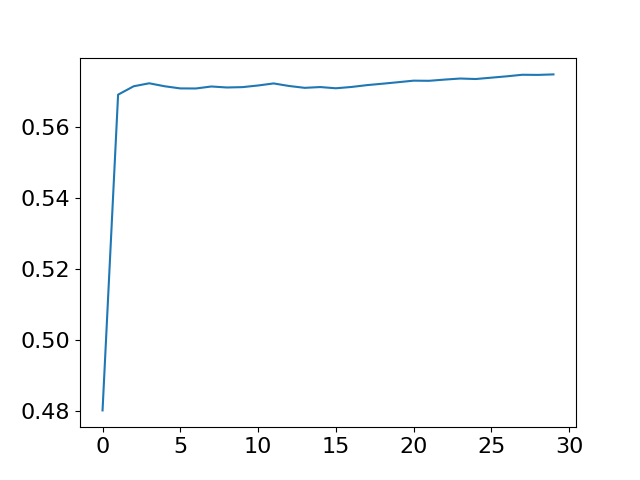

In [191]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.show()

In [225]:
def compute_vd_from_position_with_orientation(target_position, current_posture):

    current_position = control_robot(current_posture[0])
    #current_position  = np.expand_dims(current_position, 0)
    tmp = (np.array(target_position)-np.array(current_position))
    return np.expand_dims(tmp[0], 0)


def go_to_position_and_orientation(control_model, current_posture, target_position, target_orientation, nb_pass = 500):
    postures = []

    visual_direction = compute_vd_from_position_with_orientation(target_position, current_posture)

    postures.append(current_posture)

    j = 0
    while (j < nb_pass) and (np.linalg.norm(target_position - np.array(control_robot(current_posture[0]))) > 0.1):
        
        
        info = np.concatenate((visual_direction, target_orientation), axis= 1)
        
        inputs = np.expand_dims(np.concatenate([info, current_posture], axis=0), 0)

        new_command = control_model.predict(inputs)

        #new_command = command_bornee(new_command)
        current_posture = current_posture + new_command[0]
        current_posture = check_valid_posture(current_posture)

        visual_direction = compute_vd_from_position_with_orientation(target_position, current_posture)

        postures.append(current_posture)

        visual_direction = compute_vd_from_position_with_orientation(target_position, current_posture)/np.linalg.norm(visual_direction)
        j +=1

    return postures

In [230]:
target_position = [[0.2,0.24,-0.2]]
target_orientation = np.array([[pi,pi]])
postures = go_to_position_and_orientation(control_model_with_orientation, current_posture, target_position, target_orientation)
t = compute_trajectory(postures)


(501, 1, 5)


<IPython.core.display.Javascript object>


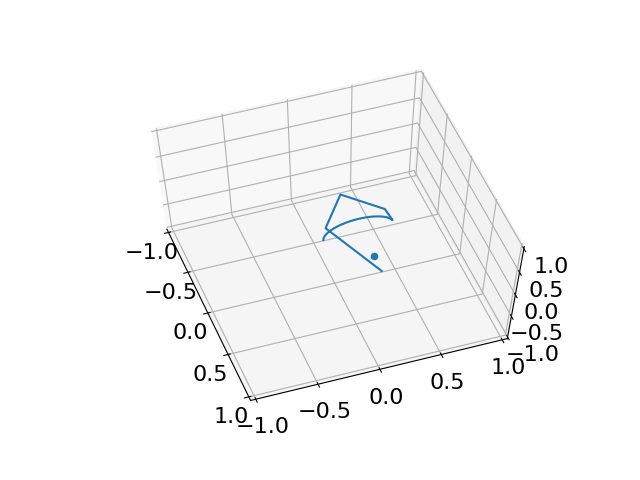

In [231]:
%matplotlib notebook

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.set_xlim(left=-1, right=1)
ax.set_ylim(bottom=-1, top=1)
ax.set_zlim(bottom=-1, top=1)
ax.plot(t[:,0], t[:,1], t[:,2])
ax.scatter(target_position[0][0],target_position[0][1],target_position[0][2])


#### Visual analysis of control model filters

### 3d visualization of neural activity

In [ ]:
%matplotlib notebook
def select_random_posture():
    posture = zeros(4)
    posture[0] = randrange(1,0,2*pi/3)
    posture[1] = randrange(1,0,2*pi/3)
    posture[2] = randrange(1,0,2*pi/3)
    return posture

def select_lin_posture(n):
    position = zeros((10*n*n, 4))
    phi1 = linspace(0,2*pi/3,n)
    phi2 = linspace(0,2*pi/3,n)
    theta1 = linspace(0,2*pi/3,n)
    xx, yy, zz = meshgrid(phi1, phi2, theta1)
    position[:,0] = xx.flatten()
    position[:,1] = yy.flatten()
    position[:,2] = zz.flatten()
    
    return position 

def select_lin_command(n):
    commands = zeros((10*n*n, 4))
    c0 = linspace(-1,1,n)*0.2
    c1 = linspace(-1,1,n)*0.2
    c2 = linspace(-1,1,n)*0.2
    cc0, cc1, cc2 = meshgrid(c0,c1,c2)
    commands[:,0] = cc0.flatten()
    commands[:,1] = cc1.flatten()
    commands[:,2] = cc2.flatten()
    
    return commands
    
def select_command():
    command = zeros(4)
    command[0] = randrange(1,-1, 1) * 0.25
    command[1] = randrange(1,-1, 1) * 0.25
    command[2] = random.choice(
        [-1, 1]) * np.sqrt(0.375 - (command[0] * command[0] + command[1] * command[1]))
    return command

def create_image_visu(posture, i):
    phi1, phi2, theta1 = posture[0], posture[1], posture[2]
    name = "visualization/%s" %i
    plot_arm(phi1, phi2, theta1, name)
    
def compute_random_activity_for_position(model, i):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    for k in (range(300)):
        posture_before = select_random_posture()
        position_before = control_robot(posture_before)
        name_before = "fig_before_%s" %k
        create_image_visu(posture_before, name_before)
        
        tmp0 = "images/visualization/" + name_before + ".png"
        
        tens_before = load_and_preprocess_image(tmp0)
        noised_tens_before = noised_image(tens_before)
        
        for j in range(10):
            res = []
            command = select_command()
            posture_after = posture_before + command
            position_after = control_robot(posture_after)
            name_after = "fig_after_%s_%s" %(k, j)
            create_image_visu(posture_after, name_after)
            
            tmp1 = "images/visualization/" + name_after + ".png"

            tens_after = load_and_preprocess_image(tmp1)
            noised_tens_after = noised_image(tens_after)
            
            t = tf.concat([noised_tens_before, noised_tens_after], -1)
            r = tf.reshape(t, [1,IMG_SIZE, IMG_SIZE, 2])
            
            
            output = model.predict(r)
            res.append(output[0][0][i])
        
        moy = mean(res)
       
        ax.scatter3D(position_before[0], position_before[1], position_before[2], color= plt.cm.Greens((moy) *2))
        
    plt.show()

def compute_activity_for_position(model, i):
    """ compute averaged-command initial-position specific neural activity
    
    Args : 
        model : a keras model object
        i : neuron index
    
    Returns : 
        null
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    postures = select_lin_posture(10)
    command = select_command()
    for k in (range(100)):
        
        posture_before = postures[k]
        position_before = control_robot(posture_before)
        name_before = "fig_before_%s" %k
        create_image_visu(posture_before, name_before)
        
        tmp0 = "images/visualization/" + name_before + ".png"
        
        tens_before = load_and_preprocess_image(tmp0)
        noised_tens_before = noised_image(tens_before)
        
        for j in range(10):
            res = []
            
            posture_after = posture_before + command
            position_after = control_robot(posture_after)
            name_after = "fig_after_%s_%s" %(k, j)
            create_image_visu(posture_after, name_after)
            
            tmp1 = "images/visualization/" + name_after + ".png"

            tens_after = load_and_preprocess_image(tmp1)
            noised_tens_after = noised_image(tens_after)
            
            t = tf.concat([noised_tens_before, noised_tens_after], -1)
            r = tf.reshape(t, [1,IMG_SIZE, IMG_SIZE, 2])
            
            
            output = model.predict(r)
            res.append(output[0][0][i])
        
        moy = mean(res)
       
        ax.scatter3D(position_before[0], position_before[1], position_before[2], color= plt.cm.seismic((moy)))
        
    plt.show()
   

In [ ]:
%matplotlib notebook
def compute_loss_vd(model, pos_init, joint_command, filter_index):
    img = generate_input_from_vd(pos_init,  joint_command)
    output = model.predict(img)
    loss = output[0][0][filter_index]
    
    return loss

#@tf.function
def generate_img_from_pos(phi1, phi2, theta1):
    
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    phi1 = tf.cast(phi1, tf.float32)
    phi2 = tf.cast(phi2, tf.float32)
    theta1 = tf.cast(theta1, tf.float32)

    x = [0, 0, L1 * tf.math.cos(phi1) * tf.math.cos(theta1), L2 *
         tf.math.cos(phi1 + phi2) * tf.math.cos(theta1)]
    y = [0, 0, L1 * tf.math.cos(phi1) * tf.math.sin(theta1), L2 *
         tf.math.cos(phi1 + phi2) * tf.math.sin(theta1)]  # ELBOW + HAND
    z = [0, 0, L1 * tf.math.sin(phi1), L2 * tf.math.sin(phi1 + phi2)]  # ELBOW + HAND
   
    ax.grid(False)
    ax.set_facecolor((0.0, 0.0, 0.0))
    ax.set_xlim(left=-0.2, right=0.2)
    ax.set_ylim(bottom=-0.2, top=0.2)
    ax.set_zlim(bottom=-0.2, top=0.2)
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.plot(x, y, z, label='shoulder', lw=5, color='white')
    
    fig.canvas.draw()
    
    x = np.array(fig.canvas.renderer.buffer_rgba())
    x = np.reshape(x, (288,432,4))
    
    tmp = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    #tmp = tf.reshape(tmp, [1,64,64,4])
    
    plt.close()
    
    return tmp


def generate_input_from_vd(pos_before, joint_command):

    pos_before = tf.reshape(pos_before, [1,4])
    img_before = generate_img_from_pos(pos_before[0][0],
                                      pos_before[0][1],
                                      pos_before[0][2])
    
    pos_after = np.add(pos_before , joint_command)
    img_after = generate_img_from_pos(pos_after[0][0],
                                      pos_after[0][1],
                                      pos_after[0][2])
    
    t =  tf.concat([img_before[:,:,:1], img_after[:,:,:1]], -1)
    t = tf.reshape(t, [1, IMG_SIZE, IMG_SIZE, 2])
    
    return t

def generate_max_vd(model, filter_index, nb_pass):
    
    list_pos_before = []
    list_loss = []
    list_joint_command = []

    for i in tqdm.tqdm(range(100)):
        
        joint_command = tf.convert_to_tensor(
            np.random.random((1,4)), dtype = 'float32')
        pos_before = tf.convert_to_tensor(
            np.random.random((1,4)), dtype='float32')

        tmp_loss = 0
        tmp_joint_command = joint_command
        
        list_pos_before.append(pos_before)
        j = 0
        #for j in (range(nb_pass)):
        while (tmp_loss < 10000) and (j < 100):
            new_joint_command = zeros((1,4))
            #new_joint_command[0][0] = random.choice([-1,-1])*randrange(1, 0, 0.2)
            #new_joint_command[0][1] = random.choice([-1,-1])*randrange(1, 0, 0.2)
            #new_joint_command[0][2] = random.choice([-1,-1])*randrange(1, 0, 0.2)
        
            new_joint_command[0][0] = random.choice([-1,1])*0.25
            new_joint_command[0][1] = random.choice([-1,1])*0.25
            new_joint_command[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command[0][0] * new_joint_command[0][0] + new_joint_command[0][1] * new_joint_command[0][1]))
            
            new_loss = compute_loss_vd(model, 
                                       pos_before, 
                                       new_joint_command, 
                                       filter_index)
            
            if (new_loss > tmp_loss) :
                tmp_loss = new_loss
                tmp_joint_command = new_joint_command
            #else : 
            #    pass
            j += 1
        list_loss.append(tmp_loss)
        list_joint_command.append(tmp_joint_command)
    
    return list_loss, list_joint_command, list_pos_before
            

In [ ]:
%matplotlib notebook
%matplotlib notebook  
def plot_max_vd(list_pos_before, list_joint_command, j):
    fig = figure(facecolor=(0.0, 0.0, 0.0))
    ax = fig.gca(projection='3d')
    for i in (range(len(list_loss))):
        
        if (list_loss[i] == 0) : #or (list_loss[i] < mean(list_loss)):
            pass
        else : 
            position_before = control_robot(list_pos_before[i][0])
            posture_after = np.add(list_pos_before[i][0],
                                   list_joint_command[i][0])
            position_after = control_robot(posture_after)
            plt.quiver(position_before[0], 
                       position_before[1], 
                       position_before[2], 
                       position_after[0], 
                       position_after[1], 
                       position_after[2], 
                       length = 0.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    figtitle = 'Receptive field of visuomotor neuron %s' %j
    plt.title(figtitle)
    plt.show()
    title = 'images/receptive_fields/rf_%s.png' %j
    savefig(title)
%matplotlib notebook   
%matplotlib notebook

In [ ]:
%matplotlib notebook
plot_max_vd(list_pos_before, list_joint_command, i)

In [ ]:
def multiple_contribution(model, nb_pass):
    pos_before1 = tf.convert_to_tensor(
        np.random.random((1,4)), dtype='float32')
    pos_before2 = tf.convert_to_tensor(
        np.random.random((1,4)), dtype='float32')
    
    list_joint_cmd1 = []
    list_joint_cmd2 = []
    pos = []
    pos.append(pos_before1)
    pos.append(pos_before2)
    
    for i in tqdm.tqdm(range(32)):
        tmp_loss1 = 0
        tmp_loss2 = 0
        
        tmp_joint_command1 = zeros((1,4))
        tmp_joint_command2 = zeros((1,4))
        
        for j in range(nb_pass):
            new_joint_command1 = zeros((1,4))
            new_joint_command1[0][0] = random.choice([-1,1])*0.25
            new_joint_command1[0][1] = random.choice([-1,1])*0.25
            new_joint_command1[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command1[0][0] * new_joint_command1[0][0] + new_joint_command1[0][1] * new_joint_command1[0][1]))
          
        
            new_joint_command2 = zeros((1,4))
            new_joint_command2[0][0] = random.choice([-1,1])*0.25
            new_joint_command2[0][1] = random.choice([-1,1])*0.25
            new_joint_command2[0][2] = random.choice([-1,1])*np.sqrt(
                0.375 -  (new_joint_command2[0][0] * new_joint_command2[0][0] + new_joint_command2[0][1] * new_joint_command2[0][1]))
            
            loss1 = compute_loss_vd(model, pos_before1, new_joint_command1, i )
            loss2 = compute_loss_vd(model, pos_before2, new_joint_command2, i )
            
            if (loss1 > tmp_loss1):
                tmp_loss1 = loss1
                tmp_joint_command1 = new_joint_command1
            
            if (loss2 > tmp_loss2):
                tmp_loss2 = loss2
                tmp_joint_command2 = new_joint_command2
                
        list_joint_cmd1.append(tmp_joint_command1)
        list_joint_cmd2.append(tmp_joint_command2)
        
    return pos, list_joint_cmd1, list_joint_cmd2
            

In [ ]:
model_encoder = encoder_conv
pos, list_joint_cmd1, list_joint_cmd2 = multiple_contribution(model, 10)

In [ ]:
%matplotlib notebook
def plot_multiple_contrib(pos, list_joint_cmd1, indice):
    fig = figure(facecolor=(0.0,0.0,0.0))
    ax = fig.gca(projection="3d")
    
    for i in tqdm.tqdm(range(32)):
        position_before = pos[indice][0]
        posture_after = np.add(position_before, list_joint_cmd1[i][0])
        position_after = control_robot(posture_after)
        plt.quiver(position_before[0],
                  position_before[1], 
                  position_before[2], 
                  position_after[0], 
                  position_after[1], 
                  position_after[2], 
                  length = 0.1, 
                  color = plt.cm.Set1(i/32.0))
    plt.show()

In [ ]:
plot_multiple_contrib(pos, list_joint_cmd1, 0)

In [ ]:
plot_multiple_contrib(pos,list_joint_cmd2, 1)

In [ ]:
def build_cornet():
    IMG_SIZE = 64
    INPUT_ENCODER_SHAPE = (IMG_SIZE, IMG_SIZE, 2)

    inputs = tf.keras.Input(shape=INPUT_ENCODER_SHAPE, name='encoder_input')

    x = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0])(inputs)
    x = tf.keras.layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(x)

    y = tf.keras.layers.Lambda(lambda x: x[:, :, :, 1])(inputs)
    y = tf.keras.layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(y)

    #fx = tf.keras.layers.Flatten()(x)
    fx = tf.keras.layers.Conv2D(filters=LATENT_DIM, kernel_size=7, strides=(
        2, 2), activation='relu', name='conv_x_1')(x)
    fx = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(fx)
    fx = tf.keras.layers.Conv2D(filters=LATENT_DIM * 2, kernel_size=3,
                                strides=(1, 1),activation='relu', name='conv_x_2')(fx)
    fx = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(fx)
    
    fx = tf.keras.layers.Flatten()(fx)
    #fx = tf.keras.layers.Dense(units=15*15*64, name = 'latent_fx1')(fx)
    fx = tf.keras.layers.Dense(LATENT_DIM, name='latent_fx2')(fx)
    fx = tf.keras.layers.Reshape((LATENT_DIM, 1,))(fx)

    #fy = tf.keras.layers.Flatten()(y)
    fy = tf.keras.layers.Conv2D(filters=LATENT_DIM, kernel_size=7, strides=(
        2, 2), activation='relu', name='conv_y_1')(y)
    fy = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(fy)
    fy = tf.keras.layers.Conv2D(filters=LATENT_DIM * 2, kernel_size=3,
                                strides=(1,1), activation='relu', name='conv_y_2')(fy)
    fy = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(fy)
    
    fy = tf.keras.layers.Flatten()(fy)
    #fy = tf.keras.layers.Dense(units=15*15*64, name = 'latent_fy1')(fy)
    fy = tf.keras.layers.Dense(LATENT_DIM, name='latent_fy2')(fy)
    fy = tf.keras.layers.Reshape((1, LATENT_DIM,))(fy)

    matmul = tf.keras.layers.Multiply()([fx, fy])

    fh = tf.keras.layers.Flatten()(matmul)
    fh = tf.keras.layers.Dense(LATENT_DIM, name='latent_fh1')(fh)
    #fh = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_fh2')(fh)
    #fh = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_fh3')(fh)

    fx = tf.keras.layers.Reshape((1, LATENT_DIM,))(fx)
    fh = tf.keras.layers.Reshape((1, LATENT_DIM,))(fh)

    outputs = tf.keras.layers.Concatenate()([fx, fh])
    encoder = tf.keras.Model(
        inputs=inputs, outputs=outputs, name='encoder_model')

    return encoder


In [ ]:
cornet = build_cornet()
cornet.summary()

In [ ]:
encoder = build_conv2D_pointwise_encoder()
encoder.summary()